## Import Neccesary Modules.

In [2]:
tf.__version__

'2.13.0'

In [1]:
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Activation, ReLU
from tensorflow.keras.layers import BatchNormalization, Conv2DTranspose, Concatenate
from tensorflow.keras.models import Model, Sequential

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def convolution_operation(entered_input, filters=64):
    # Taking first input and implementing the first conv block
    conv1 = Conv2D(filters, kernel_size = (3,3), padding = "same")(entered_input)
    batch_norm1 = BatchNormalization()(conv1)
    act1 = ReLU()(batch_norm1)
    
    # Taking first input and implementing the second conv block
    conv2 = Conv2D(filters, kernel_size = (3,3), padding = "same")(act1)
    batch_norm2 = BatchNormalization()(conv2)
    act2 = ReLU()(batch_norm2)
    
    return act2

In [3]:
def encoder(entered_input, filters=64):
    # Collect the start and end of each sub-block for normal pass and skip connections
    enc1 = convolution_operation(entered_input, filters)
    MaxPool1 = MaxPooling2D(strides = (2,2))(enc1)
    return enc1, MaxPool1

In [4]:
def decoder(entered_input, skip, filters=64):
    # Upsampling and concatenating the essential features
    Upsample = Conv2DTranspose(filters, (2, 2), strides=2, padding="same")(entered_input)
    Connect_Skip = Concatenate()([Upsample, skip])
    out = convolution_operation(Connect_Skip, filters)
    return out

In [5]:
def U_Net(Image_Size):
    # Take the image size and shape
    input1 = Input(Image_Size)
    
    # Construct the encoder blocks
    skip1, encoder_1 = encoder(input1, 64)
    skip2, encoder_2 = encoder(encoder_1, 64*2)
    skip3, encoder_3 = encoder(encoder_2, 64*4)
    skip4, encoder_4 = encoder(encoder_3, 64*8)
    
    # Preparing the next block
    conv_block = convolution_operation(encoder_4, 64*16)
    
    # Construct the decoder blocks
    decoder_1 = decoder(conv_block, skip4, 64*8)
    decoder_2 = decoder(decoder_1, skip3, 64*4)
    decoder_3 = decoder(decoder_2, skip2, 64*2)
    decoder_4 = decoder(decoder_3, skip1, 64)
    
    out = Conv2D(1, 1, padding="same", activation="sigmoid")(decoder_4)

    model = Model(input1, out)
    return model

In [6]:
!ls /kaggle/input/final-tweezer-dataset/cropped_dataset_final

images	masks


In [7]:
input_shape = (512, 512, 3)
model = U_Net(input_shape)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 512, 512, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 512, 512, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 re_lu (ReLU)                (None, 512, 512, 64)         0         ['batch_normalization[0][0

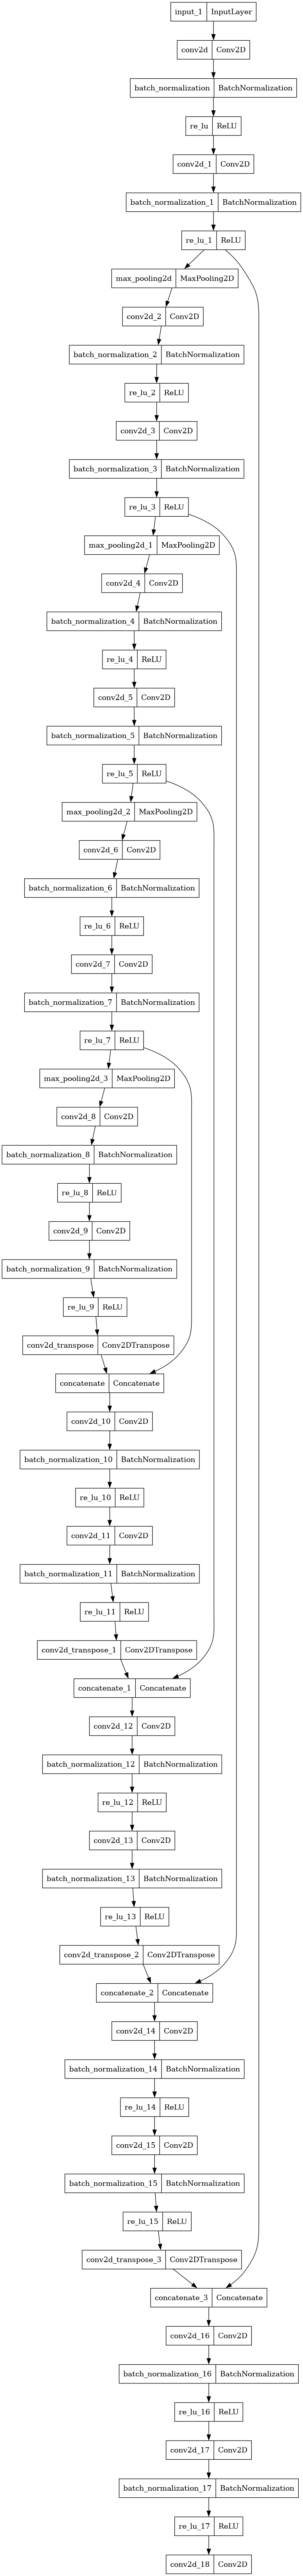

In [8]:
tf.keras.utils.plot_model(model, "model.png", show_shapes=False, show_dtype=False, show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96)

In [9]:
import os

input_dir = "/kaggle/input/final-tweezer-dataset/cropped_dataset_final/images"
target_dir = "/kaggle/input/final-tweezer-dataset/cropped_dataset_final/masks"
img_size = (input_shape[0], input_shape[1])
num_classes = 1
batch_size = 8

input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".tiff")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".tiff") and not fname.startswith(".")
    ]
)

print("Number of samples:", len(input_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)

Number of samples: 697
/kaggle/input/final-tweezer-dataset/cropped_dataset_final/images/00000.tiff | /kaggle/input/final-tweezer-dataset/cropped_dataset_final/masks/00000_mask.tiff
/kaggle/input/final-tweezer-dataset/cropped_dataset_final/images/00001.tiff | /kaggle/input/final-tweezer-dataset/cropped_dataset_final/masks/00001_mask.tiff
/kaggle/input/final-tweezer-dataset/cropped_dataset_final/images/00002.tiff | /kaggle/input/final-tweezer-dataset/cropped_dataset_final/masks/00002_mask.tiff
/kaggle/input/final-tweezer-dataset/cropped_dataset_final/images/00003.tiff | /kaggle/input/final-tweezer-dataset/cropped_dataset_final/masks/00003_mask.tiff
/kaggle/input/final-tweezer-dataset/cropped_dataset_final/images/00004.tiff | /kaggle/input/final-tweezer-dataset/cropped_dataset_final/masks/00004_mask.tiff
/kaggle/input/final-tweezer-dataset/cropped_dataset_final/images/00005.tiff | /kaggle/input/final-tweezer-dataset/cropped_dataset_final/masks/00005_mask.tiff
/kaggle/input/final-tweezer-d

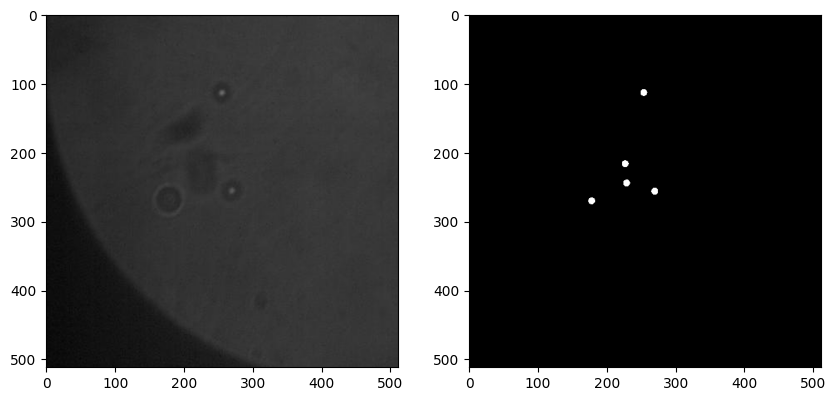

In [4]:
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
import matplotlib.pyplot as plt

# Display input image 
fig, ax = plt.subplots(1, 2, figsize=[10, 10])

ax[0].imshow(load_img("/kaggle/input/final-tweezer-dataset/cropped_dataset_final/images/00000.tiff"))
ax[1].imshow(load_img("/kaggle/input/final-tweezer-dataset/cropped_dataset_final/masks/00000_mask.tiff"))

plt.show()

In [5]:
# Define function for normalization of the image
import numpy as np
def normimg(img):
    sz = img.shape
    img = np.array(img.ravel(), dtype = np.float32)
    imgnorm = (img - img.min())/((img.max() - img.min()))
    imgnorm = np.reshape(imgnorm, sz)
    return imgnorm
    

In [6]:
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img


class TweezerSeg(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = normimg(np.array(load_img(path, target_size=self.img_size)))
            x[j] = img
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = normimg(np.array(load_img(path, target_size=self.img_size, color_mode="grayscale")))
            y[j] = np.expand_dims(img, 2)
            # Ground truth labels are 1, 2, 3. Subtract one to make them 0, 1, 2:
            #y[j] -= 1
        return x, y

In [11]:
import random
# Split our img paths into a training and a validation set
val_samples = 100
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Instantiate data Sequences for each split
train_gen = TweezerSeg(
    batch_size, img_size, train_input_img_paths, train_target_img_paths
)
val_gen = TweezerSeg(batch_size, img_size, val_input_img_paths, val_target_img_paths)

In [12]:
import os
final_image_list_dir = os.listdir('/kaggle/input/cropped-dataset-final-jan/cropped_dataset')

In [13]:
final_image_list_dir.sort()

In [15]:
import tensorflow as tf

# Load the model
model = tf.keras.models.load_model("/kaggle/working/final_tweezer_new.tf")


In [16]:
final_image_list_dir

['00000.tiff',
 '00001.tiff',
 '00002.tiff',
 '00003.tiff',
 '00004.tiff',
 '00005.tiff',
 '00006.tiff',
 '00007.tiff',
 '00008.tiff',
 '00009.tiff',
 '00010.tiff',
 '00011.tiff',
 '00012.tiff',
 '00013.tiff',
 '00014.tiff',
 '00015.tiff',
 '00016.tiff',
 '00017.tiff',
 '00018.tiff',
 '00019.tiff',
 '00020.tiff',
 '00021.tiff',
 '00022.tiff',
 '00023.tiff',
 '00024.tiff',
 '00025.tiff',
 '00026.tiff',
 '00027.tiff',
 '00028.tiff',
 '00029.tiff',
 '00030.tiff',
 '00031.tiff',
 '00032.tiff',
 '00033.tiff',
 '00034.tiff',
 '00035.tiff',
 '00036.tiff',
 '00037.tiff',
 '00038.tiff',
 '00039.tiff',
 '00040.tiff',
 '00041.tiff',
 '00042.tiff',
 '00043.tiff',
 '00044.tiff',
 '00045.tiff',
 '00046.tiff',
 '00047.tiff',
 '00048.tiff',
 '00049.tiff',
 '00050.tiff',
 '00051.tiff',
 '00052.tiff',
 '00053.tiff',
 '00054.tiff',
 '00055.tiff',
 '00056.tiff',
 '00057.tiff',
 '00058.tiff',
 '00059.tiff',
 '00060.tiff',
 '00061.tiff',
 '00062.tiff',
 '00063.tiff',
 '00064.tiff',
 '00065.tiff',
 '00066.ti

## We will be saving the predicted masks as images.

- Read each image numpy array as Tensorflow Tensor Array. 
- Pass the image array through the model for prediction.

## Visualize using Train gen and Test Gen

In [17]:
import numpy
tempimg = train_gen.__getitem__(2)[0][1]

In [18]:
tempimgnorm = normimg(tempimg)

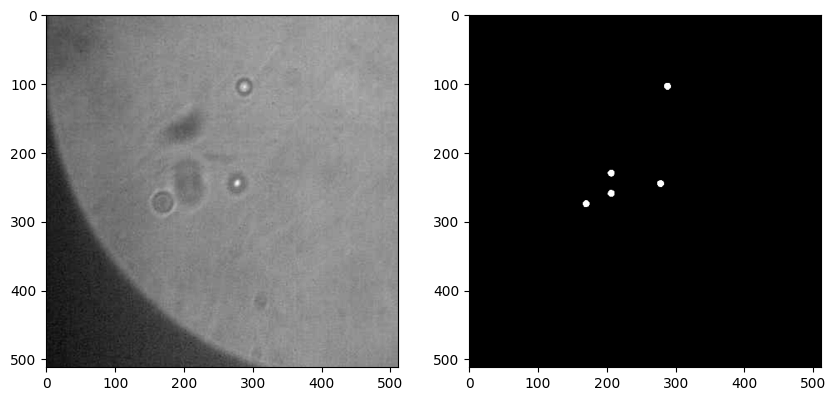

In [19]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize = [10, 10])

for i in range(2):
    tempimg = train_gen.__getitem__(2)[i][3]
    ax[i].imshow(tempimg, cmap = 'gray')
    
plt.show()

In [20]:
model.compile(optimizer= tf.keras.optimizers.Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    weight_decay=None,
    clipnorm=None,
    clipvalue=None,
    global_clipnorm=None,
    use_ema=False,
    ema_momentum=0.99,
    ema_overwrite_frequency=None,
    jit_compile=True,
    name='Adam')
, loss=tf.keras.losses.BinaryCrossentropy(from_logits=False))

callbacks = [
    keras.callbacks.ModelCheckpoint("final_tweezer_new.tf", save_best_only=True, save_format="tf")
]

# Train the model, doing validation at the end of each epoch.
epochs = 15
history = model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

Epoch 1/15
74/74 [==============================] - 236s 2s/step - loss: 0.0801 - val_loss: 2.8819
Epoch 2/15
74/74 [==============================] - 169s 2s/step - loss: 0.0198 - val_loss: 0.0271
Epoch 3/15
74/74 [==============================] - 168s 2s/step - loss: 0.0135 - val_loss: 0.0167
Epoch 4/15
74/74 [==============================] - 168s 2s/step - loss: 0.0110 - val_loss: 0.0141
Epoch 5/15
74/74 [==============================] - 159s 2s/step - loss: 0.0080 - val_loss: 0.0184
Epoch 6/15
74/74 [==============================] - 168s 2s/step - loss: 0.0057 - val_loss: 0.0093
Epoch 7/15
74/74 [==============================] - 168s 2s/step - loss: 0.0047 - val_loss: 0.0083
Epoch 8/15
74/74 [==============================] - 169s 2s/step - loss: 0.0040 - val_loss: 0.0070
Epoch 9/15
74/74 [==============================] - 169s 2s/step - loss: 0.0035 - val_loss: 0.0050
Epoch 10/15
74/74 [==============================] - 169s 2s/step - loss: 0.0032 - val_loss: 0.0034
Epoch 11/

## Plot the test and the validation losses...



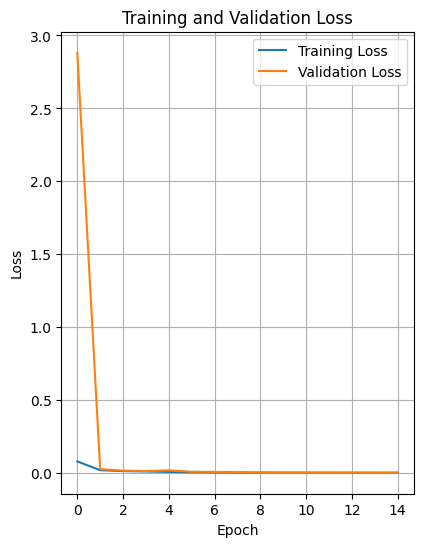

In [21]:
# Plot the training and validation loss
plt.figure(figsize=(10, 6))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Predict some model outputs...

In [22]:
# Display some model outputs
num_samples_to_display = 5  # You can change this number based on your preference
# Generate predictions on the validation set
val_predictions = model.predict(val_gen)

12/12 [==============================] - 8s 615ms/step


In [22]:
val_gen

In [20]:
list_of_inputs = [i for i in val_gen]

In [21]:
val_prediction = model.predict(list_of_inputs[0][0])

1/1 [==============================] - 0s 461ms/step


In [22]:
val_prediction.shape

(8, 512, 512, 1)

In [23]:
list_of_inputs[0][1][0].shape

(512, 512, 1)

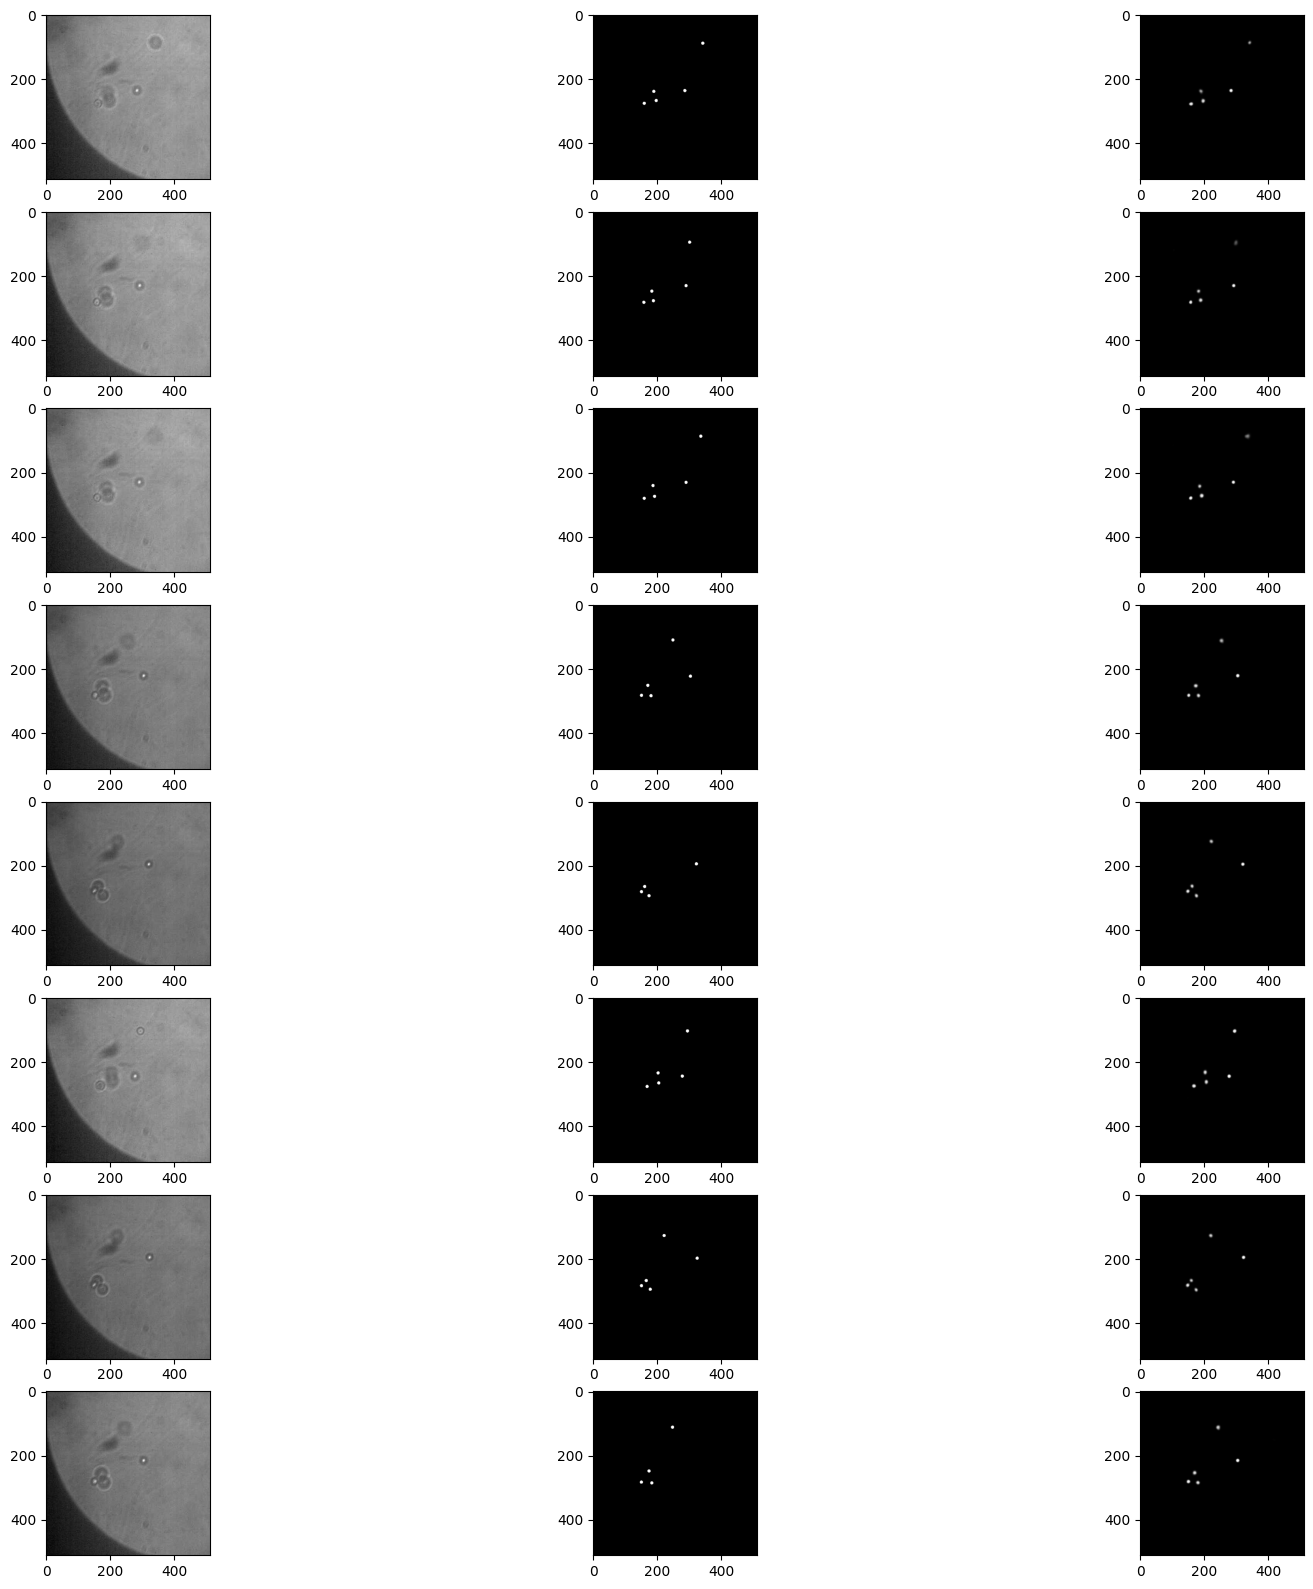

In [24]:
# Compare the Input ground truth and the model predictions
import matplotlib.pyplot as plt
import numpy as np  # Assuming you have some image data

# Generate some example image data (replace this with your actual image data)

fig, ax = plt.subplots(8, 3, figsize =(20, 20))

for i in range(8):
    for j in range(3):
        
        if j == 2:
            ax[i, j].imshow(val_prediction[i].squeeze(), cmap='gray')
        elif j==1:
            ax[i, j].imshow(list_of_inputs[0][1][i], cmap='gray')  # Use 'cmap' if your images are grayscale
        elif j==0:
            ax[i, j].imshow(list_of_inputs[0][0][i], cmap='gray')
            
            
plt.show()


In [ ]:
list_of_inputs = list(val_gen)

## Pass the input dataset through your model and then save the generated masks 

- We will save all the mask as tiffile

# Downloading the `final_tweezer_new.tf` directory

In [25]:
!pwd

/kaggle/working


In [26]:
!zip -r final_tweezer_new.zip final_tweezer_new.tf

  adding: final_tweezer_new.tf/ (stored 0%)
  adding: final_tweezer_new.tf/fingerprint.pb (stored 0%)
  adding: final_tweezer_new.tf/variables/ (stored 0%)
  adding: final_tweezer_new.tf/variables/variables.index (deflated 76%)
  adding: final_tweezer_new.tf/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: final_tweezer_new.tf/keras_metadata.pb (deflated 95%)
  adding: final_tweezer_new.tf/saved_model.pb (deflated 91%)


In [ ]:
import tifffile
for i, image in enumerate(images):
    tifffile.imwrite(f"image_{i+1}.tif", image, photometric='grayscale')


## Visible Advantages of this algorithm

- No more watershed type algorithm required in order to visibly separate and localise the beads. 
- Taken care of the dust particles, not localised. 
- Hidden Latent features to human eyes as visible are visible to the network as well
- Low Contrast feature identified, lets see the tracking results.
- Now implying the Kalman filtering algorithm to track the moving beads.
- Tracking algorithm movement.
- Implement a lookup table track the movement in the 3D space, and implement the cross correlation in order to know the depth of particular bead 
- In the inset also obtain the tracker, depth value and the contrast.

### Test the Validation Dataset

In [ ]:
# Currently there are total 25 batches..
# Each batch contains 8 images in datapoints...
# Each dataset contain Image, Ground Truth Mask...
# Visualizing the sample validation dataset...
from PIL import Image
import matplotlib.pyplot as plt
num_samples = 8 #(max = 8)
fig, ax = plt.subplots(num_samples, 4, figsize=(8, 20))

ioulist = []
for i in range(num_samples):
    ax[i, 0].imshow(sample_batch[0][i])
    ax[i, 0].set_xticks([])
    ax[i, 0].set_yticks([])
    ax[i, 0].set_title("Input Image")
    
for i in range(num_samples):
    ax[i, 1].imshow(sample_batch[1][i], cmap = 'gray')
    ax[i, 1].set_xticks([])
    ax[i, 1].set_yticks([])
    ax[i, 1].set_title("Ground Truth Mask")
    
# Calculate IoUs

threshold = 0.8

for i in range(num_samples):
    target = np.array(sample_batch[1][i].squeeze(-1), dtype = 'uint8')
    predicted = np.array(np.where(val_predictions[i] > threshold, 1, 0).squeeze(-1), dtype='uint8')
    intersection = np.logical_and(target, predicted)
    union = np.logical_or(target, predicted)
    iou = np.sum(intersection) / np.sum(union)
    ioulist.append(iou)
    
#Threshold the array

for i in range(num_samples):
    predicted_mask = np.where(val_predictions[i] > threshold, 1, 0)
    ax[i, 2].imshow(np.array(predicted_mask.squeeze(-1), dtype='uint8'), cmap = 'gray')
    ax[i, 2].set_xticks([])
    ax[i, 2].set_yticks([])
    ax[i, 2].set_title("Predicted Mask")
    
    
for i in range(num_samples):
    
    ax[i, 3].text(0.5, 0.5, f'IoU: {ioulist[i]:.2f}', fontsize=12, ha='center', va='center')
    ax[i, 3].axis('off')
   
plt.show()




In [ ]:
model.load

## Test your Model on Actual Tweezer dataset





In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def load_images_from_folder(folder_path):
    images = []
    for filename in os.listdir(folder_path):
        img = tf.keras.preprocessing.image.load_img(os.path.join(folder_path, filename))
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        images.append(img_array)
    return np.array(images)

def create_image_generator(folder_path, batch_size, image_size):
    image_datagen = ImageDataGenerator(rescale=None)  # You can add more augmentations as needed

    images = load_images_from_folder(folder_path)

    # Create a data generator for training
    exp_generator = image_datagen.flow_from_directory(
        "/kaggle/input/tweezer-cropped/",
        batch_size=batch_size,
        target_size=(512, 512),
    )

    return exp_generator

In [ ]:

folder_path = "/kaggle/input/tweezer-cropped/cropped_dataset"
batch_size = 8

exp_generator = create_image_generator(folder_path, batch_size, img_size)


In [ ]:
sample_exp_data = next(exp_generator)

In [ ]:
exp_predictions = model(sample_exp_data[0])

In [ ]:
num_samples = 8
fig, ax = plt.subplots(num_samples, 2, figsize = [50, 90])
for i in range(num_samples):
    ax[i, 1].imshow(np.array(exp_predictions[i]).squeeze(-1), cmap = 'gray')
    ax[i, 1].set_title('Predicted Mask')
    
for i in range(num_samples):
    ax[i, 0].imshow(normimg(np.array(sample_exp_data[0][i])), cmap = 'gray')
    ax[i, 0].set_title('Experimental Dataset')
plt.show()

In [ ]:
!pwd

In [ ]:
model.save("final_tweezer_model.keras")

In [ ]:
checkpoint_path = "/kaggle/working/"
model.save_weights(checkpoint_path.format(epoch=10))

In [ ]:
model

In [ ]:
## Load the weights...
model.load_weights("/kaggle/working/final_tweezer_model.keras")


In [ ]:


# Re-evaluate the model...
loss, acc = model.evaluate(val_input_img_paths, val_target_img_paths, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))